In [ ]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from scipy.stats import spearmanr

plt.style.use("default")


In [ ]:
#Reading the data
trade_cols = [
    "Account", "Coin", "Execution Price", "Size USD", "Side",
    "Timestamp IST", "Closed PnL", "Fee"
]
trades = pd.read_csv(
    "/content/drive/MyDrive/Colab Notebooks/ds_aiyan/csv_files/historical_data.csv",
    usecols=trade_cols,
    parse_dates=["Timestamp IST"]
)

sentiment = pd.read_csv(
    "/content/drive/MyDrive/Colab Notebooks/ds_aiyan/csv_files/fear_greed_index.csv"
)


In [ ]:
trades["Timestamp IST"] = pd.to_datetime(
    trades["Timestamp IST"],
    errors="coerce"
)
sentiment["date"] = pd.to_datetime(sentiment["date"], errors="coerce").dt.normalize()


In [ ]:
trades["date"] = trades["Timestamp IST"].dt.normalize()


In [ ]:
print(trades["Timestamp IST"].dtype)
print(trades["date"].head())


datetime64[ns]
0   2024-02-12
1   2024-02-12
2   2024-02-12
3   2024-02-12
4   2024-02-12
Name: date, dtype: datetime64[ns]


In [ ]:
trades.isna().sum()
sentiment.isna().sum()


,0
timestamp,0
value,0
classification,0
date,0


In [ ]:
sentiment.isna().sum()


,0
timestamp,0
value,0
classification,0
date,0


In [ ]:
#Aggregate behavior
daily_trades = trades.groupby("date").agg(
    total_pnl=("Closed PnL", "sum"),
    avg_pnl=("Closed PnL", "mean"),
    total_volume=("Size USD", "sum"),
    avg_trade_size=("Size USD", "mean"),
    trade_count=("Size USD", "count"),
    total_fees=("Fee", "sum")
).reset_index()


In [ ]:
#Buy/Sell bias
side_bias = (
    trades.groupby(["date", "Side"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

daily_trades = daily_trades.merge(side_bias, on="date", how="left")


In [ ]:
#merge with fear/greed
df = daily_trades.merge(
    sentiment[["date", "value", "classification"]],
    on="date",
    how="inner"
)


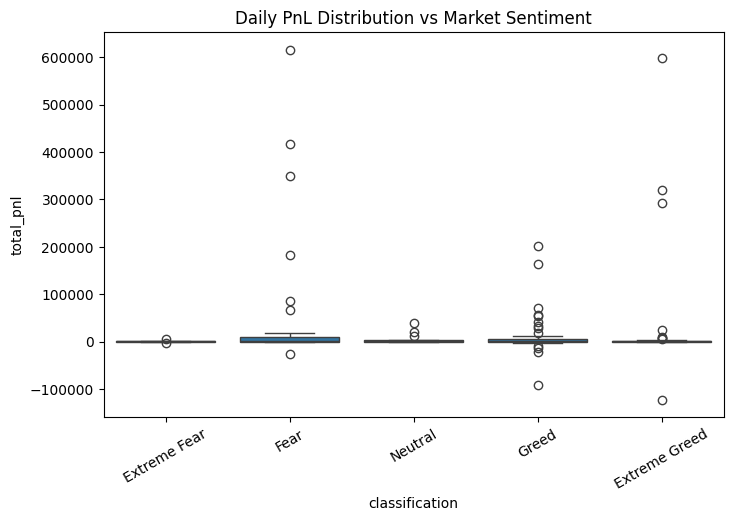

In [ ]:
#Core EDA
plt.figure(figsize=(8,5))
sns.boxplot(
    x="classification",
    y="total_pnl",
    data=df,
    order=["Extreme Fear", "Fear", "Neutral", "Greed", "Extreme Greed"]
)
plt.title("Daily PnL Distribution vs Market Sentiment")
plt.xticks(rotation=30)
plt.show()


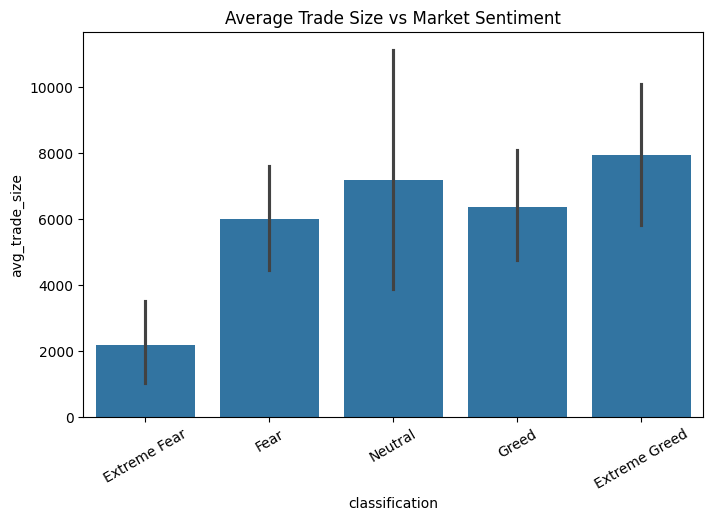

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(
    x="classification",
    y="avg_trade_size",
    data=df,
    order=["Extreme Fear", "Fear", "Neutral", "Greed", "Extreme Greed"]
)
plt.title("Average Trade Size vs Market Sentiment")
plt.xticks(rotation=30)
plt.show()


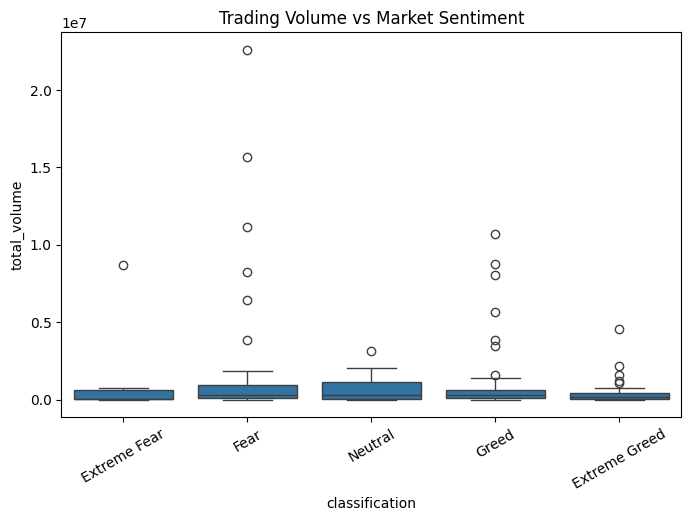

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(
    x="classification",
    y="total_volume",
    data=df,
    order=["Extreme Fear", "Fear", "Neutral", "Greed", "Extreme Greed"]
)
plt.title("Trading Volume vs Market Sentiment")
plt.xticks(rotation=30)
plt.show()


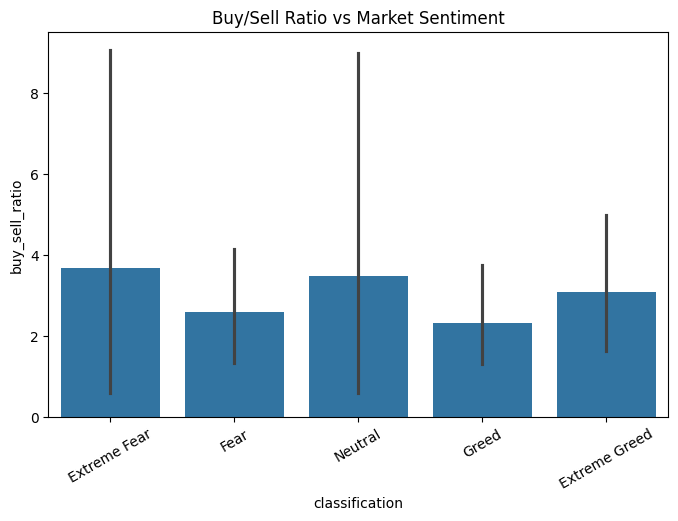

In [ ]:
df["buy_sell_ratio"] = df["BUY"] / (df["SELL"] + 1)

plt.figure(figsize=(8,5))
sns.barplot(
    x="classification",
    y="buy_sell_ratio",
    data=df,
    order=["Extreme Fear", "Fear", "Neutral", "Greed", "Extreme Greed"]
)
plt.title("Buy/Sell Ratio vs Market Sentiment")
plt.xticks(rotation=30)
plt.show()


In [ ]:
df["sentiment_lag_1"] = df["value"].shift(1)
df["sentiment_lag_3"] = df["value"].shift(3)

df.dropna(inplace=True)


In [ ]:
corr_1, _ = spearmanr(df["sentiment_lag_1"], df["total_pnl"])
corr_3, _ = spearmanr(df["sentiment_lag_3"], df["total_pnl"])

print("Spearman Correlation (1-day lag):", round(corr_1, 3))
print("Spearman Correlation (3-day lag):", round(corr_3, 3))


Spearman Correlation (1-day lag): -0.066
Spearman Correlation (3-day lag): 0.014


In [ ]:
extreme_fear = df[df["classification"] == "Extreme Fear"]
extreme_greed = df[df["classification"] == "Extreme Greed"]

print("Avg PnL after Extreme Fear:", extreme_fear["total_pnl"].mean())
print("Avg PnL during Extreme Greed:", extreme_greed["total_pnl"].mean())


Avg PnL after Extreme Fear: 733.3227585
Avg PnL during Extreme Greed: 26904.504083162792


In [ ]:
print("Median PnL during Extreme Fear:", extreme_fear["total_pnl"].median())
print("Median PnL during Extreme Greed:", extreme_greed["total_pnl"].median())


Median PnL during Extreme Fear: 64.56941950000001
Median PnL during Extreme Greed: 541.55471


In [ ]:
print("PnL Std (Extreme Fear):", extreme_fear["total_pnl"].std())
print("PnL Std (Extreme Greed):", extreme_greed["total_pnl"].std())


PnL Std (Extreme Fear): 2798.334049232614
PnL Std (Extreme Greed): 112472.21201428777


In [ ]:
df_sorted = df.sort_values("date")

df_sorted["future_pnl_1d"] = df_sorted["total_pnl"].shift(-1)

after_extreme_fear = df_sorted[df_sorted["classification"] == "Extreme Fear"]

print(
    "Avg next-day PnL after Extreme Fear:",
    after_extreme_fear["future_pnl_1d"].mean()
)


Avg next-day PnL after Extreme Fear: 61692.653320833335


In [ ]:
def sentiment_signal(row):
    if row["classification"] == "Extreme Fear":
        return "BUY"
    elif row["classification"] == "Extreme Greed":
        return "SELL"
    else:
        return "HOLD"

df["strategy_signal"] = df.apply(sentiment_signal, axis=1)


In [ ]:
summary = df.groupby("classification").agg(
    avg_pnl=("total_pnl", "mean"),
    avg_volume=("total_volume", "mean"),
    avg_trade_size=("avg_trade_size", "mean"),
    avg_buy_sell_ratio=("buy_sell_ratio", "mean")
)

print(summary)


                     avg_pnl    avg_volume  avg_trade_size  avg_buy_sell_ratio
classification                                                                
Extreme Fear      733.322758  1.596707e+06     2191.149008            3.672657
Extreme Greed   26904.504083  4.238084e+05     7954.335976            3.077626
Fear            49422.932852  2.213164e+06     6177.280138            2.580814
Greed           11086.582984  1.032392e+06     6200.670401            2.338887
Neutral          4977.116132  7.926364e+05     7300.789351            3.551868
